In [9]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

# NORMALIZATION WILL BE ACROSS ELECTRODE

In [10]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/non-hierarchical/L_SHIE/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)

In [11]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][ ...] for param in named_params]

subjects = sorted(df['participant'].unique())
# subjects = encoder_dict['participant'].inverse_transform(subjects)

positions = sorted(df['compound_position'].unique())
# positions = encoder_dict['compound_position'].inverse_transform(positions)
positions

charges = sorted(df["compound_charge_params"].unique())     # Sort the encoded charges so they are in the same order as the posterior samples
# charges = encoder_dict['compound_charge_params'].inverse_transform(charges)     # Then decode the charges, this maintains the order of the charges
muscles = model.response

In [12]:
charges

[0, 1]

In [13]:
encoder_dict['compound_charge_params'].inverse_transform(charges)

array(['20-0-80-25', '50-0-50-100'], dtype=object)

In [14]:
a.shape

(4000, 8, 4, 2, 6)

In [15]:
arr = a

In [16]:
arr.shape

(4000, 8, 4, 2, 6)

In [17]:
a_norm = arr / ma.median(arr, axis=(2,3,4), keepdims=True)

In [18]:
a_norm.shape

(4000, 8, 4, 2, 6)

In [19]:
a_norm_mean = ma.mean(a_norm, axis=(0))

In [20]:
a_norm_mean.shape

(8, 4, 2, 6)

In [21]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/L_SHIE/cst_selectivity_means.pkl"
with open(src, "rb") as f:
    sel = pickle.load(f)

In [22]:
sel.shape

(8, 4)

In [23]:
a_norm_psuedo = a_norm_mean[:,:,0,:]

In [24]:
eff = ma.mean(a_norm_psuedo, axis = -1)

In [25]:
sem_eff = stats.sem(1/eff, axis=0)
sem_eff

array([0.11632256, 0.06520116, 0.05728962, 0.05903631])

In [26]:
avg_eff = ma.mean(1/eff, axis=0)
avg_sel = ma.mean(sel, axis=0)

In [27]:
positions

[0, 1, 2, 3]

In [28]:
eff.shape

(8, 4)

In [29]:
encoder_dict['compound_position'].inverse_transform(positions)

array(['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC'], dtype=object)

In [30]:
avg_eff = avg_eff[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [31]:
sem_eff = stats.sem(1/eff, axis=0)
sem_sel = stats.sem(sel, axis=0)


In [ ]:
sem_eff

array([0.11632256, 0.06520116, 0.05728962, 0.05903631])

In [32]:
ind = [0,3]

In [ ]:
(1/eff[ind]).shape

(2, 4)

(2, 4)

In [ ]:
eff.shape

(8, 4)

In [33]:
eff_mono = eff[...]

In [34]:
eff_mono.shape

(8, 4)

In [35]:
sel[0,:]

masked_array(data=[0.5481451537049663, 0.7952708213773961,
                   1.134334531003984, 0.6488785376644013],
             mask=[False, False, False, False],
       fill_value=1e+20)

In [36]:
sel[:,ind].shape

(8, 2)

In [37]:
(1/eff_mono[:,ind]).shape

(8, 2)

In [38]:
combined = np.stack((sel[:,ind],1/eff_mono[:,ind]), axis=-1)

In [39]:
combined = combined.reshape(8,2,2)


In [40]:
combined.shape

(8, 2, 2)

In [41]:
combined[:,1,0].mean()

1.0718089834796747

In [42]:
(1/eff_mono[:,ind])[0]

masked_array(data=[1.031852386616107, 0.7149941523658276],
             mask=[False, False],
       fill_value=1e+20)

(0.4, 1.8)

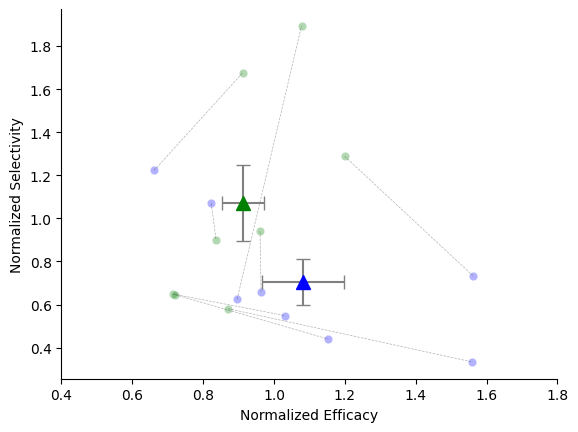

In [57]:
measure_colors = ['black', 'green', 'red', 'blue']
label = encoder_dict['compound_position'].inverse_transform(positions)
label = label[ind]

for i in range(8):
    arr = combined[i, ...]
    sns.lineplot(y=arr[:, 0], x=arr[:, 1], linestyle="--", color="k", linewidth=0.5, alpha=0.3)
    sns.scatterplot(y=[arr[0, 0]], x=[arr[0, 1]], marker="o", color="blue", alpha=0.3)
    sns.scatterplot(y=[arr[1, 0]], x=[arr[1, 1]], marker="o", color="green", alpha=0.3)
  
plt.errorbar(
    x=avg_eff[ind][0], 
    y=avg_sel[ind][0], 
    yerr=sem_sel[ind][0], 
    xerr=sem_eff[ind][0], 
    fmt='^', 
    capsize=5, 
    ms=10, 
    ecolor='gray', 
    mec='blue', 
    mfc='blue'
)

plt.errorbar(
    x=avg_eff[ind][1], 
    y=avg_sel[ind][1], 
    yerr=sem_sel[ind][1], 
    xerr=sem_eff[ind][1], 
    fmt='^', 
    capsize=5, 
    ms=10, 
    ecolor='gray', 
    mec='green', 
    mfc='green'
)    
# plt.errorbar(x=avg_eff[ind], y=avg_sel[ind], yerr=sem_sel[ind], xerr=sem_eff[ind], fmt='^', capsize=5,ms = 10, ecolor='gray')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()
plt.xlim(0.4, 1.8)
    

In [ ]:
measure_colors = ['black', 'green', 'red', 'blue']
label = encoder_dict['compound_position'].inverse_transform(positions)
label = label[ind]

for i in range(8):
    for m in range(2):
        x_vals_center = 1 / combined[i, 0, 0]  
        y_vals_center = combined[i, 1, 0]
        
        x_vals_hd = 1 / combined[i, 0, 1]  
        y_vals_hd = combined[i, 1, 1]

        


AttributeError: module 'seaborn' has no attribute 'plot'

(0.4, 1.8)

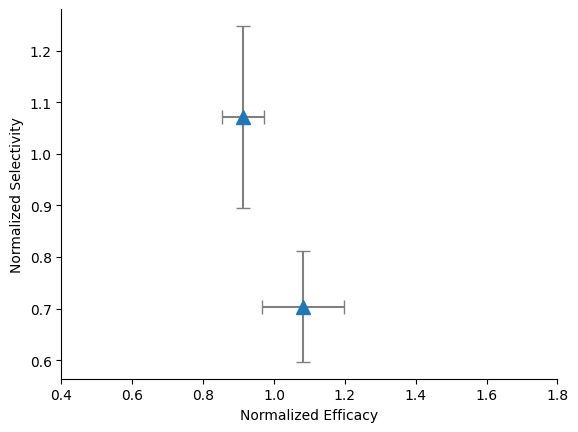

In [49]:
plt.errorbar(x=avg_eff[ind], y=avg_sel[ind], yerr=sem_sel[ind], xerr=sem_eff[ind], fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Normalized Efficacy")
plt.ylabel("Normalized Selectivity")
sns.despine()
plt.xlim(0.4, 1.8)

In [20]:
diff = a_norm_mean[:,:,None,...] - a_norm_mean[:,None,...]

In [22]:
diff.shape

(8, 4, 4, 6)

In [23]:
diff_mean = ma.mean(diff, axis=(-1))

In [24]:
encoder_dict['compound_position'].inverse_transform(positions)

array(['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC'], dtype=object)

In [11]:
encoder_dict['compound_charge_params'].inverse_transform(charges)

array(['20-0-80-25', '50-0-50-100'], dtype=object)

In [25]:
norm_y = []
norm_x = []
charge_ind = 0
target_position = 1

for subject_ind, subject in enumerate(subjects):
    for m_ind, m in enumerate(muscles):
    # Fix the subject index and size index
        a_temp = a[:, subject_ind, :, charge_ind, m_ind]
        mean_thres = np.nanmean(a_temp[:,target_position,...],axis=(0))
        curr_params = [
            params[:, subject_ind, :, charge_ind, m_ind, None] for params in params
        ]

        x_temp = np.array([1.2*mean_thres])[None, None, None, :]

        temp_thresh = F.rectified_logistic(
            x_temp, #x_temp
            *curr_params
        )
        
        # Remove offset
        temp_thresh = temp_thresh - curr_params[2]
        norm_y.append(temp_thresh)
        norm_x.append(x_temp)

norm_x = np.array(norm_x)
norm_x = norm_x.reshape(len(subjects), len(muscles), *norm_x.shape[2:])
norm_y = np.array(norm_y)
norm_y = norm_y.reshape(len(subjects), len(muscles), *norm_y.shape[2:])
norm_y = ma.masked_invalid(norm_y)

In [38]:
norm_y.shape

(8, 6, 4000, 4, 1)

In [39]:
y_means = ma.mean(norm_y, axis=(2,4))

In [40]:
y_means.shape

(8, 6, 4)

In [40]:
a_norm_mean.shape

(8, 4, 6)

In [15]:
a_norm_mean.shape

(8, 4, 2, 6)

In [16]:
y_diffs = a_norm_mean[:,:,None,:,:] - a_norm_mean[:,None,:,:,:]

In [17]:
y_diffs.shape

(8, 4, 4, 2, 6)

In [43]:
y_diffs_means = ma.mean(y_diffs,axis=1)

In [63]:
y_diffs_means.shape

(8, 4, 6)

In [45]:
pvalues = []
for i in range(len(positions)):
    for i2 in range(len(positions)):
        if i==i2:
            pvalues.append(1)
            continue
        temp_p = stats.wilcoxon(diff_mean[:, i,i2], axis=0).pvalue
        pvalues.append(temp_p)

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(len(positions), len(positions))

In [46]:
labels = encoder_dict['compound_position'].inverse_transform(positions)

In [49]:
a_norm_mean.shape

(8, 4, 6)

In [52]:
pvalues.shape

(4, 4)

In [54]:
(y_diffs_means.mean(axis=0).data).shape

(4, 6)

In [64]:
a_norm_mean_graph = ma.mean(y_diffs, axis=(0,3))

In [65]:
a_norm_mean_graph.shape

(4, 4)

In [68]:
pvalues.shape

(4, 4)

<Axes: >

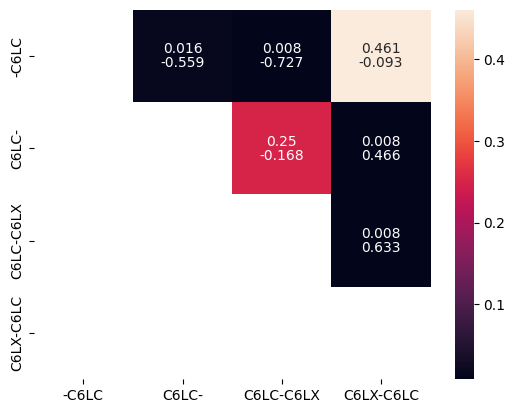

In [69]:
mask = np.tril(np.ones_like(pvalues), k=0).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(a_norm_mean_graph, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)

In [ ]:
y_means.shape

(8, 6, 4)

In [ ]:
(ma.mean(y_means[:,:,0],axis=1) - ma.mean(y_means[:,:,1],axis=1))

masked_array(data=[0.5913226912063999, 0.21475500405032538,
                   0.8655596165958164, 2.6655280098736354,
                   0.23036097840613357, 0.6386057419815189,
                   0.7452741813954753, 1.1058151052114606],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

In [ ]:
encoder_dict['compound_position'].inverse_transform(positions)

array(['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC'], dtype=object)

In [ ]:
encoder_dict['compound_charge_params'].inverse_transform(charges)     # Then decode thcharges

array(['20-0-80-25', '50-0-50-100'], dtype=object)